In [ ]:
# !pip install rank_bm25 --quiet #install BM25
# !pip install --no-binary :all: nmslib #install nmslib
# !pip install ftfy
import pandas as pd
import os
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
from rank_bm25 import BM25Okapi
import ftfy
import nmslib
import time

In [ ]:
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')

In [9]:
organizations1 = pd.read_csv('organizations.csv')
organizations2 = pd.read_csv('organization_descriptions.csv')

In [10]:
organizations1.head()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,legal_name,roles,domain,homepage_url,country_code,state_code,region,city,address,postal_code,status,short_description,category_list,category_groups_list,num_funding_rounds,total_funding_usd,total_funding,total_funding_currency_code,founded_on,last_funding_on,closed_on,employee_count,email,phone,facebook_url,linkedin_url,twitter_url,logo_url,alias1,alias2,alias3,primary_role,num_exits,revenue_range
0,b531d0a8-52dd-4189-91d1-3d7432d78d71,Meridian Entertainment Group,organization,meridian-entertainment-group,https://www.crunchbase.com/organization/meridian-entertainment-group,585500.0,2017-11-10 19:44:02,2019-03-30 01:33:40,NaN,company,meridianconcerts.com,http://meridianconcerts.com,NaN,NaN,NaN,NaN,NaN,NaN,operating,"Meridian Entertainment Group provides with event and entertainment consultation, programming and management services in Michigan.","Consulting,Events","Events,Media and Entertainment",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-10,info@meridianconcerts.com,231-935-3900,https://www.facebook.com/meridianentertainmentgroup,NaN,https://www.twitter.com/meridianconcert,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1509753042/iirm0g9yl4qxexn8uooc.jpg",NaN,NaN,NaN,company,NaN,NaN
1,094dbc9c-ca77-ec1c-4a92-be1092ef1052,RushRate,organization,rushrate,https://www.crunchbase.com/organization/rushrate,602764.0,2016-11-14 11:59:52,2018-02-12 23:27:40,NaN,company,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,operating,Ranking potential members of a fraternity.,"Communities,Internet","Community and Lifestyle,Internet Services",1.0,NaN,NaN,NaN,NaN,2016-10-01,NaN,unknown,NaN,NaN,NaN,NaN,NaN,"https://crunchbase-production-res.cloudinary.com/image/upload/h_120,w_120,f_jpg/v1507847753/placeholder_zgpxrr.png",NaN,NaN,NaN,company,NaN,NaN
2,d103ef85-1ac5-e952-2784-1d8f321aa0b3,Bishop Canevin High School,organization,bishop-canevin-high-school,https://www.crunchbase.com/organization/bishop-canevin-high-school,483700.0,2016-05-18 18:53:33,2018-10-26 21:47:45,NaN,school,bishopcanevin.org,http://bishopcanevin.org/,USA,PA,Pennsylvania,Pittsburgh,2700 Morange Road,15205,operating,"Bishop Canevin High School is a Catholic high school in Pittsburgh, Pennsylvania.","E-Learning,Education,Higher Education","Education,Software",NaN,NaN,NaN,NaN,1958-08-17,NaN,NaN,101-250,info@bishopcanevin.org,412.456.3000,https://www.facebook.com/bishopcanevin,https://www.linkedin.com/company/bishop-canevin-high-school,https://twitter.com/bishopcanevin,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1463597520/imq2izxki4y29jkynpit.jpg",NaN,NaN,NaN,school,NaN,NaN
3,0fbfb7ac-4015-1561-6d42-ec9c4a87a324,Paladina Health,organization,paladina-health,https://www.crunchbase.com/organization/paladina-health,7675.0,2016-09-02 08:49:36,2018-10-26 23:08:51,NaN,company,paladinahealth.com,http://www.paladinahealth.com,USA,CO,Colorado,Denver,1551 Wewatta Street,80202,acquired,Paladina Health is an innovative employer-sponsored healthcare provider.,"Health Care,Hospital,Medical,Personal Health",Health Care,1.0,165000000.0,165000000.0,USD,2010-01-01,2018-08-23,NaN,11-50,memberservices@paladinahealth.com,303-405-2100,https://www.facebook.com/206019739569801,https://www.linkedin.com/company/paladina-health,https://www.twitter.com/paladinahealth,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1472806170/sm4hopceixrj5dtprlwq.png",NaN,NaN,NaN,company,NaN,NaN
4,1ec47fa1-0727-4a87-b872-7128ec94e7cd,Spire Group,organization,spire-group-pc,https://www.crunchbase.com/organization/spire-group-pc,520650.0,2018-12-17 09:57:58,2018-12-17 10:02:14,NaN,company,spirecpa.com,http://www.spirecpa.com,USA,NJ,New Jersey,Clark,100 Walnut Avenue Suite 103,07066,acquired,Spire Group is a full-service accounting and consulting firm.,"Accounting,Consulting","Financial Services,Professional Services",NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN,https://w

In [11]:
organizations2.head()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,description
0,65c154f7-8992-4c2e-99c4-e755089987c8,Old Liquors Invest,organization,old-liquors-invest,https://www.crunchbase.com/organization/old-liquors-invest,310817.0,2019-01-25 11:49:42,2019-02-14 01:18:05,"The Corporate bonds Series OLI-III-B is offered by Old Liquors Invest III B.V. The issuer has as its principal activity the speculative investing in old beverages such as Whiskey, Cognac, Armagnac, Port, Liqueurs, Madeira wines, and other rare and old or special alcoholic beverages."
1,bd565ade-4b23-4bb0-b965-97fb95b95775,Padoq,organization,padoq,https://www.crunchbase.com/organization/padoq,41514.0,2017-10-09 11:59:00,2018-05-02 09:27:38,"Padoq is a community network platform revolutionising the way communities interact, engage, and make payments online. Launching - June 2018."
2,5a6370b5-1176-473f-a27d-49e75cd49edf,Mainland,organization,mainland,https://www.crunchbase.com/organization/mainland,340555.0,2018-06-19 04:07:17,2018-10-26 22:44:46,"Enrich lives. That's what we're all about. It's the reason we come to work every day. It's the life blood that flows through all aspects of the company. Loneliness sucks. Everyone knows this because everyone has experienced it at one point or another. But if someone doesn't want to be lonely and truly want more friends, shouldn't there be an easy way to make that happen? Well we think so. How do we enrich lives? By simply bringing people together. A new best friend could be right around the corner. So join us. Because here at Mainland we understand no one's and island."
3,8b8fe41c-07dc-4039-b311-022381af39f5,Kaffeen,organization,kaffeen,https://www.crunchbase.com/organization/kaffeen,63096.0,2019-04-01 17:14:25,2019-04-01 23:14:03,"Kaffeen mobile application is the first mobile application in Saudi Arabia that is specialized in online coffee ordering. It allows users to order/pre-order their coffee online and pick it up, with no extra charge, from the pick-up counter. If want to save time, or simply do not want to wait in line, Kaffeen is your go-to mobile application."
4,786293a8-f675-40d8-8516-430c8f4c236a,Webstage,organization,webstage,https://www.crunchbase.com/organization/webstage,442866.0,2018-02-13 05:20:36,2019-03-25 20:27:17,"WebStage is a Target Fuel technology that was born when experts in the fields of online marketing, website personalization and web analytics teamed up to make website marketing less “technical”. Websites have always presented a challenge for marketers who don’t have a computer science degree. Most of the time, someone else codes the website, someone else oversees the website, and someone else owns the website! WebStage provides easy ways to personalize content without delays or technical expertise. It allows any marketer to quickly and easily add or alter web content to keep on-site visitors informed and engaged. In minutes, marketers can launch personalized content on any number of pages for different target audiences - a task that typically takes weeks and cost thousands."


In [12]:
org1_cols = ['uuid','name','type','permalink','rank','short_description']
org2_cols =['uuid','name','type','permalink','rank','description']
org1 = organizations1[org1_cols]
org2 = organizations2[org2_cols]

In [17]:
org1 = org1.rename(columns = {'short_description':'description'})

In [18]:
final_orgs = pd.concat([org1,org2])
final_orgs = final_orgs.reset_index()

In [19]:
final_orgs.nunique()

index          50 
uuid           100
name           100
type           1  
permalink      100
rank           100
description    100
dtype: int64

In [21]:
final_orgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        100 non-null    int64  
 1   uuid         100 non-null    object 
 2   name         100 non-null    object 
 3   type         100 non-null    object 
 4   permalink    100 non-null    object 
 5   rank         100 non-null    float64
 6   description  100 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 5.6+ KB


In [22]:
df = final_orgs.copy()

In [23]:
df['text'] = df['name'] + ' ' + df['permalink']+ ' ' + df['description']
df.shape

(100, 8)

In [24]:
df.head(1)

,index,uuid,name,type,permalink,rank,description,text
0,0,b531d0a8-52dd-4189-91d1-3d7432d78d71,Meridian Entertainment Group,organization,meridian-entertainment-group,585500.0,"Meridian Entertainment Group provides with event and entertainment consultation, programming and management services in Michigan.","Meridian Entertainment Group meridian-entertainment-group Meridian Entertainment Group provides with event and entertainment consultation, programming and management services in Michigan."


### Preprocess and tokenise

#### Simple Search using BM25 Algorithm

In [39]:
nlp = spacy.load("en_core_web_sm")
text_list = df.text.str.lower().values
tok_text=[] # for our tokenised corpus
#Tokenising using SpaCy:
for doc in tqdm(nlp.pipe(text_list, disable=["tagger", "parser","ner"])):
   tok = [t.text for t in doc if t.is_alpha]
   tok_text.append(tok)

100it [00:00, 920.38it/s]


In [40]:
bm25 = BM25Okapi(tok_text)

In [45]:
df.head(1)

,index,uuid,name,type,permalink,rank,description,text
0,0,b531d0a8-52dd-4189-91d1-3d7432d78d71,Meridian Entertainment Group,organization,meridian-entertainment-group,585500.0,"Meridian Entertainment Group provides with event and entertainment consultation, programming and management services in Michigan.","Meridian Entertainment Group meridian-entertainment-group Meridian Entertainment Group provides with event and entertainment consultation, programming and management services in Michigan."


In [79]:
def search1(query):
  tokenized_query = query.lower().split(" ")
  import time
  t0 = time.time()
  results = bm25.get_top_n(tokenized_query, df.text.values, n=3)
  t1 = time.time()
  print(f'Searched 100 records in {round(t1-t0,3) } seconds \n')
  for i in results:
    org = df[df['text']==i]['name']
    print(f"Search results: {i} \nOrganizations: {org} \n")

In [93]:
search1('Eureka')

Searched 100 records in 0.0 seconds 

Search results: Eureka King Inc. eureka-king Eureka king enables publishers to maximize the life-time value of their users across web and mobile, by delivering actionable, responsive and sequential user notifications throughout the user journey. In 2014, companies spent $46 BN to acquire traffic to their websites. However, less than 10% of traffic yielded long-term value for the businesses. We engineered Eureka King to guide your visitors through a deliberate user journey, mapped for maximum value.  Eureka King's behavior-tracking engine analyzes users actions and intent in Real-time to deliver optimal user-prompts. Our dynamic user-prompts adapt to the users' journey and enables publishers to intelligently promote a product, encourage signups, transact payments, and a variety of transactions customized for the publisher’s needs. Using our SaaS platform, clients were able to boost conversion rates by 3x, and retention rates by 2x. Clients include K

In [81]:
search1('Consulting firm')

Searched 100 records in 0.001 seconds 

Search results: Spire Group spire-group-pc Spire Group is a full-service accounting and consulting firm. 
Organizations: 4    Spire Group
Name: name, dtype: object 

Search results: Binary Mango binary-mango Hi-tech Development Firm 
Organizations: 48    Binary Mango
Name: name, dtype: object 

Search results: ALBERT albert-2 ALBERT offers businesses with analytics and consulting services to assist them in their business decision making. 
Organizations: 38    ALBERT
Name: name, dtype: object 



In [80]:
search1('Whiskey')

Searched 100 records in 0.0 seconds 

Search results: Old Liquors Invest old-liquors-invest The Corporate bonds Series OLI-III-B is offered by Old Liquors Invest III B.V. The issuer has as its principal activity the speculative investing in old beverages such as Whiskey, Cognac, Armagnac, Port, Liqueurs, Madeira wines, and other rare and old or special alcoholic beverages. 
Organizations: 50    Old Liquors Invest
Name: name, dtype: object 

Search results: Fully Functional fully-functional Allied Healthcare and Health resource website 
Organizations: 36    Fully Functional
Name: name, dtype: object 

Search results: WTSP-TV wtsp-tv WTSP-TV is a broadcast media company offering news, breaking news, weather, and live streaming services. 
Organizations: 26    WTSP-TV
Name: name, dtype: object 



#### Smart Search using fasttext, BM25 and NMSLIB

In [29]:
nlp = spacy.load("en_core_web_sm")
tok_text=[] # for our tokenised corpus
text = df.text.str.lower().values
text = [ftfy.fix_text(str(i)) for i in text]
#Tokenising using SpaCy:
for doc in tqdm(nlp.pipe(text, n_threads=2, disable=["tagger", "parser","ner"])):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_text.append(tok)

100it [00:00, 773.78it/s]


In [30]:
ft_model = FastText(
    sg=1, # use skip-gram: usually gives better results
    size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model.build_vocab(tok_text)

ft_model.train(
    tok_text,
    epochs=6,
    total_examples=ft_model.corpus_count, 
    total_words=ft_model.corpus_total_words)

ft_model.save('_fasttext.model')

In [31]:
ft_model = FastText.load('_fasttext.model')

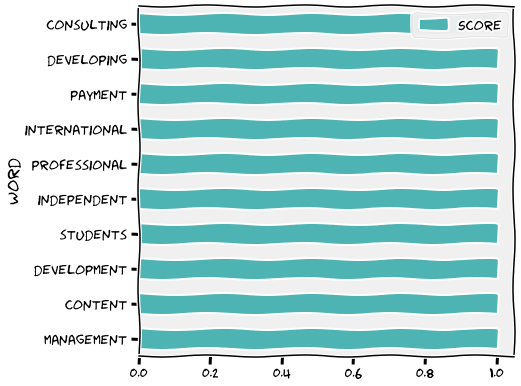

In [32]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("entertainment", topn=10, restrict_vocab=5000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

In [55]:
bm25 = BM25Okapi(tok_text)
weighted_doc_vects = []

for i,doc in tqdm(enumerate(tok_text)):
  doc_vector = []
  for word in doc:
    vector = ft_model.wv[word]
    weight = (bm25.idf[word] * ((bm25.k1 + 1.0)*bm25.doc_freqs[i][word])) 
    / 
    (bm25.k1 * (1.0 - bm25.b + bm25.b *(bm25.doc_len[i]/bm25.avgdl))+bm25.doc_freqs[i][word])
    weighted_vector = vector * weight
    doc_vector.append(weighted_vector)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects.append(doc_vector_mean)

100it [00:00, 650.90it/s]


In [56]:
pickle.dump( weighted_doc_vects, open( "weighted_doc_vects.p", "wb" ) )

In [57]:
with open( "weighted_doc_vects.p", "rb" ) as f:
  weighted_doc_vects = pickle.load(f)
# create a random matrix to index
data = np.vstack(weighted_doc_vects)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

In [89]:
# querying the index:

def search2(input):
  input = input.lower().split()

  query = [ft_model[vec] for vec in input]
  query = np.mean(query,axis=0)

  t0 = time.time()
  ids, distances = index.knnQuery(query, k=5)
  t1 = time.time()
  print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
  for i,j in zip(ids,distances):
    val = df.text.values[i]
    print(f"\nSearch result: {df.text.values[i]} \nOrganization: {df[df['text']==val]['name']} \n")


In [94]:
search2('Melhor')

Searched 100 records in 0.0001 seconds 


Search result: O Melhor Fornecedor o-melhor-fornecedor O Melhor Fornecedor is an online B2B marketplace that enables its users to find qualified suppliers to fulfill their needs. It enables them to receive quotes for free, compare prices, find suppliers within a limited location, and more. 
Organization: 61    O Melhor Fornecedor
Name: name, dtype: object 


Search result: Webstage webstage WebStage is a Target Fuel technology that was born when experts in the fields of online marketing, website personalization and web analytics teamed up to make website marketing less “technical”. Websites have always presented a challenge for marketers who don’t have a computer science degree. Most of the time, someone else codes the website, someone else oversees the website, and someone else owns the website! WebStage provides easy ways to personalize content without delays or technical expertise. It allows any marketer to quickly and easily add or alter we

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [91]:
search2('Meridian groups')

Searched 100 records in 0.0001 seconds 


Search result: Meridian Entertainment Group meridian-entertainment-group Meridian Entertainment Group provides with event and entertainment consultation, programming and management services in Michigan. 
Organization: 0    Meridian Entertainment Group
Name: name, dtype: object 


Search result: Tech Groupz tech-groupz Tech Groupz is a Google apps authorized dealer running their show from last 5 years with dedication and this dedication is shown when they talk about the number of clients. Till Now Tech Groupz have more than 500 clients in all over India who is fully satisfied with their service. In coming time company is going to expand their service with latest technology as they always keep themselves according to trend. 
Organization: 81    Tech Groupz
Name: name, dtype: object 


Search result: The Fashion Institute of Design & Merchandising the-fashion-institute-of-design-merchandising-san-francisco To make a living out of your personal cre

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
